<span style="color:#26488F; font-size:30px; font-weight: bold;">  Predictive Maintenance Classification </span>

<html>
<body>
<div style="color:#435987;
            border-style: solid;
            border-radius: 25px;
            border-color: #435987;
            padding-left: 10px">
       
<span style="color:#26488F; font-size:20px; font-weight: bold;">  Brief Description </span><br>
    
This dataset reflects real predictive maintenance encountered in the industry with measurements from real equipment. The features description is taken directly from the dataset source. <br>
<br>
<span style="font-weight: bold;"> The six features are: </span> <br>
<li>Type: the quality of the product, consisting of a letter L, M, or H. Meaning low, medium, and high, respectively. <br>
<li>Air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K.<br>
<li>Process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature<br> plus 10 K.<br>
<li>Rotational speed [rpm]: calculated from power of 2860 W, overlaid with a normally distributed noise.<br>
<li>Torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.<br>
<li>Tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.<br>
<br>

<span style="font-weight: bold;"> The targets are: </span> <br>
<li>Target: failure or no failure (to perform binary classification).<br>
<li>Failure Type: type of failure (to perform multiclass classification).<br>

<br>
It also includes the following information, which is not useful for building the models:<br>
<li>UID: unique identifier ranging from 1 to 10000.<br>
<li>ProductID: the id of the product.<br>
    
</p>
</div>

</body>
</html>

<span style="color:#26488F; font-size:28px; font-weight: bold;">  Importing libraries </span> 

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier, EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss, ClusterCentroids
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, roc_curve, precision_recall_curve
import pickle
sns.set()

<span style="color:#26488F; font-size:28px; font-weight: bold;">  Loading data and first impressions </span> 

In [36]:
raw_data = pd.read_csv('predictive_maintenance.csv')
df = raw_data.copy()
df.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure

In [37]:
df.describe()

UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]        Target  
count            10000.000000  10000.000000     10000.000000  10000.000000  
mean              1538.776100     39.986910       107.951000      0.033900  
std                179.284096      9.968934        63.654147      0.180981  
min               1168.000000      3.800000         0.000000      0.000000  
25%               1423.000000     33.200000        53.000000      0.000000  
50%               1503.000000     40.100000       108.000000      0.000000  
75%               1612.000000     46.800000       162.000000      0.000000  
max               2886.000000     76.600000       253.000000      1.000000

**Quick insights:** 
* There are 10.000 instances in the dataset
* The are no missing values (every feature has 10.000 observations)
* Target variable are ones and zeros
* UDI seems to be an index number
* Product ID is an identification number. Hence, it can be removed

In [38]:
# Checking unique values for 'UDI' and 'Product ID'
print(f"{df['UDI'].nunique()} unique values for 'UDI'")
print(f"{df['Product ID'].nunique()} unique value for 'Pruduct ID'")

10000 unique values for 'UDI'
10000 unique value for 'Pruduct ID'


In [39]:
# Dropping 'UDI' and 'Product ID' from the dataset
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)

In [40]:
# Let's change the name of the columns.
df = df.rename(mapper={'Air temperature [K]': 'Air temperature',
                       'Process temperature [K]': 'Process temperature',
                       'Rotational speed [rpm]': 'Rotational speed',
                       'Torque [Nm]': 'Torque', 
                       'Tool wear [min]': 'Tool wear'}, axis=1)

In [41]:
# Taking a look at 'Failure Type' variable
df['Failure Type'].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

This target variable assumes six possible values: no failure, or five different types of failure.


**Quick insight:** We can see that the dataset is highly unbalanced. Let's further check that with the 'target' variable:


In [42]:
df['Target'].value_counts(normalize=True)

Target
0    0.9661
1    0.0339
Name: proportion, dtype: float64



The dataset is indeed very unbalanced
 

In [43]:
# Rechecking for missing values
df.isna().sum()

Type                   0
Air temperature        0
Process temperature    0
Rotational speed       0
Torque                 0
Tool wear              0
Target                 0
Failure Type           0
dtype: int64

In [44]:
df['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

'Type' assumes three possible values. Later on they will be hot or ordinal encoded.

In [45]:
# Taking a look at the data types
df.dtypes

Type                    object
Air temperature        float64
Process temperature    float64
Rotational speed         int64
Torque                 float64
Tool wear                int64
Target                   int64
Failure Type            object
dtype: object

'Type' and 'Failure Type' are strings.

<span style="color:#26488F; font-size:18px; font-weight: bold;">  Target variables </span>

There are two target variables: 'Target' and 'Failure Type'.

In [46]:
# Checking types of failure
df['Failure Type'].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

There are 5 types of failure + not failure.

Now, let's check if there are inconsistencies between 'Target' and 'Failure Type': 


In [47]:
df_failure = df[df['Target'] == 1]
df_failure['Failure Type'].value_counts()

Failure Type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: count, dtype: int64

 9 values are classified as failure in the 'Target' variable but as No Failure in the 'Failure Type' variable. Let's check in the dataset:

In [48]:
df_failure[df_failure['Failure Type'] == 'No Failure']

Type  Air temperature  Process temperature  Rotational speed  Torque  \
1437    H            298.8                309.9              1439    45.2   
2749    M            299.7                309.2              1685    28.9   
4044    M            301.9                310.9              1419    47.7   
4684    M            303.6                311.8              1421    44.8   
5536    M            302.3                311.8              1363    54.0   
5941    L            300.6                310.7              1438    48.5   
6478    L            300.5                309.8              1663    29.1   
8506    L            298.4                309.6              1710    27.3   
9015    L            297.2                308.1              1431    49.7   

      Tool wear  Target Failure Type  
1437         40       1   No Failure  
2749        179       1   No Failure  
4044         20       1   No Failure  
4684        101       1   No Failure  
5536        119       1   No Failure  
5941         78       1   No Failure  
6478        145       1   No Failure  
8506        163       1   No Failure  
9015        210       1   No Failure


It could go both ways, either failure or no failure. I think it would make sense to remove those instances since I do not know the real target here.


In [49]:
index_possible_failure = df_failure[df_failure['Failure Type'] == 'No Failure'].index
df.drop(index_possible_failure, axis=0, inplace=True)



Let's check the same but for 'Target' variable equal to zero (no failure):
    

In [50]:
df_failure = df[df['Target'] == 0]
df_failure['Failure Type'].value_counts()

Failure Type
No Failure         9643
Random Failures      18
Name: count, dtype: int64

**Second warning!!** Similarly, we have 18 instances classifed as Random Failures by 'Failure Type', whereas they are classifed as No failure by the 'Target Variable'. These 18 instances are in fact all instaces of 'Random Failures'.
Again, let's check and remove those instances as we do not really know if they belong to Failure class or not. Hence, we will end up with 4 types of failures since 'Random Failures' will be removed altogether.

In [51]:
df_failure[df_failure['Failure Type'] == 'Random Failures']

Type  Air temperature  Process temperature  Rotational speed  Torque  \
1221    M            297.0                308.3              1399    46.4   
1302    L            298.6                309.8              1505    45.7   
1748    H            298.4                307.7              1626    31.1   
2072    L            299.6                309.5              1570    35.5   
2559    L            299.3                309.0              1447    50.4   
3065    M            300.1                309.2              1687    27.7   
3452    H            301.6                310.5              1602    32.3   
5471    L            302.7                312.3              1346    61.2   
5489    L            302.6                312.1              1499    35.0   
5495    H            302.9                312.5              1357    55.0   
5509    L            302.8                312.2              1509    36.5   
5553    L            302.5                311.9              1306    59.7   
5639    L            302.6                312.1              1668    28.7   
6091    L            300.9                310.7              1412    57.5   
6913    L            300.8                311.2              1481    38.5   
6960    L            300.7                311.0              1413    52.0   
7488    L            300.3                311.7              1545    43.5   
7868    H            300.4                311.9              1438    46.7   

      Tool wear  Target     Failure Type  
1221        132       0  Random Failures  
1302        144       0  Random Failures  
1748        166       0  Random Failures  
2072        189       0  Random Failures  
2559        140       0  Random Failures  
3065         95       0  Random Failures  
3452          2       0  Random Failures  
5471        170       0  Random Failures  
5489        215       0  Random Failures  
5495         12       0  Random Failures  
5509         52       0  Random Failures  
5553        172       0  Random Failures  
5639        180       0  Random Failures  
6091         16       0  Random Failures  
6913        181       0  Random Failures  
6960         91       0  Random Failures  
7488        160       0  Random Failures  
7868         41       0  Random Failures

In [52]:
index_possible_failure = df_failure[df_failure['Failure Type'] == 'Random Failures'].index
df.drop(index_possible_failure, axis=0, inplace=True)

27 instaces were removed (0.27% of the entire dataset). Of which:
   * 9 belonged to class **Failure in 'Target'** variable and **No failure in target 'Failure Type'**
   * 18 belonged to class **No failure in 'Target'** variable and **Random failures in target 'Failure Type'**

In [53]:
# We can check that all 27 instances were removed from the dataset:
df.shape[0]

9973

In [54]:
# Let's reset the index
df.reset_index(inplace=True, drop=True)

<span style="color:#26488F; font-size:28px; font-weight: bold;">  Explanatory Data Analysis (EDA) </span>

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Correlation </span>

C:\Users\vishw\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\vishw\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\vishw\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\vishw\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

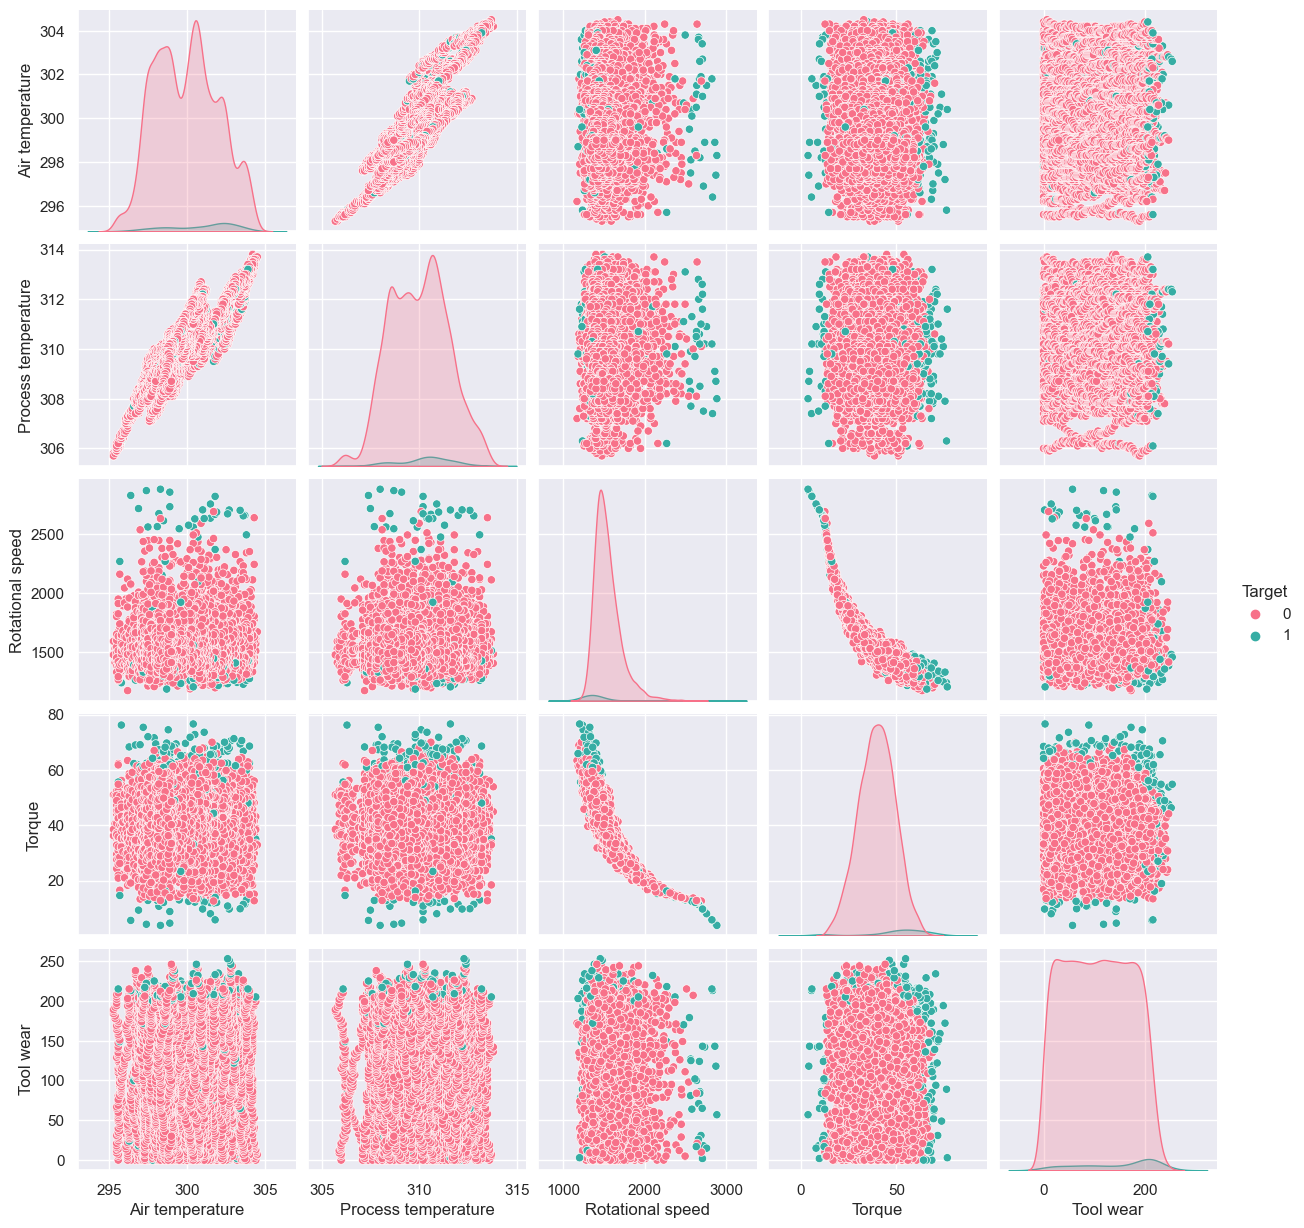

In [55]:
sns.pairplot(df, hue='Target', palette='husl')

**Insights:** 
* Torque and rotational speed are highly correlated.
* Process temperature and air temperature are also highly correlated.
* We immediately see that failures occur for extreme values of some features, i.e., the machinery fails either for the lowest or largest values of torque and rotational speed. This is easily spotted in the graph since the green dots are far apart for those features. So, there is a range for normal conditions in which the machines operate, and above or under this range, they tend to fail.

Let's plot a violin chart to see how torque and rotational speed behave:

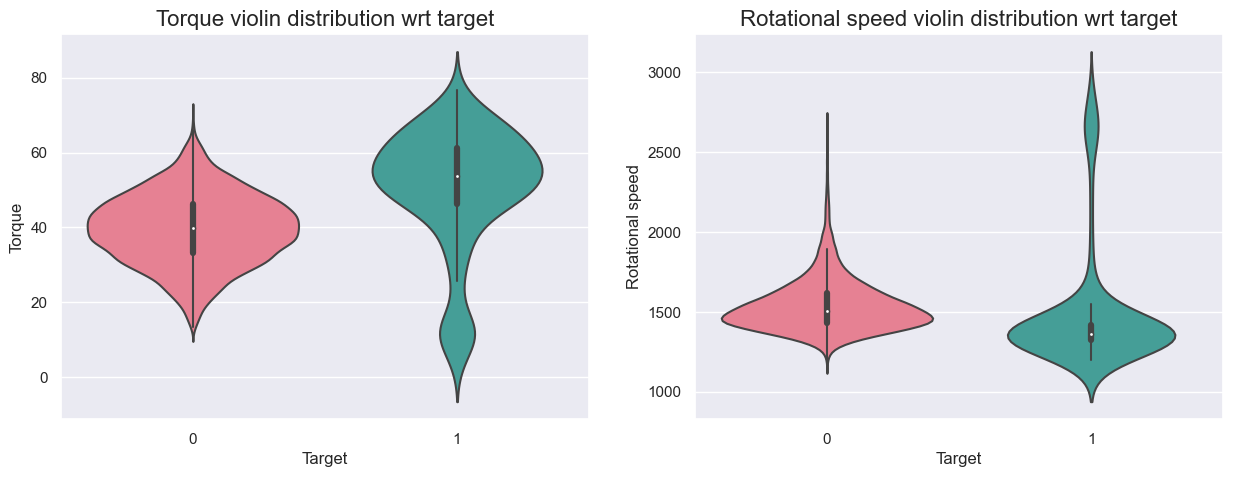

In [56]:
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16

fig, axes = plt.subplots(1, 2, figsize=[15,5])
axes = axes.flatten()
j=0

for i in ['Torque', 'Rotational speed']:
    sns.violinplot(data=df, x='Target', y=i, ax=axes[j], palette='husl')
    axes[j].set_title(i + ' violin distribution wrt target', )
    j += 1

**Insight:** Regarding torque and rotational speed, it can be seen again that most failures are triggered for much lower or much higher values than the mean when not failing.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Percentage of failure </span>

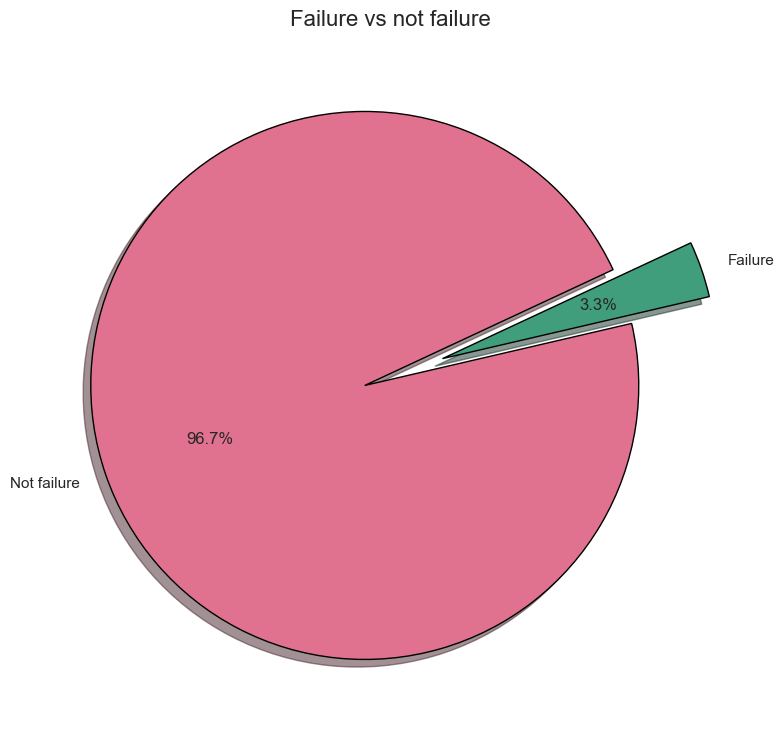

In [57]:
colors = ['#E1728F', '#409E7D'] 
plt.pie(df['Target'].value_counts(),  explode=[0.1, 0.2], labels=['Not failure', 'Failure'],
        autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25,
        colors=colors)
plt.title('Failure vs not failure')
plt.tight_layout()
plt.show()

**Insight:** as mentioned before, highly unbalanced dataset.

<span style="color:#26488F; font-size:22px; font-weight: bold;"> Correllation Heatmap </span>

plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True)
plt.show()

As mentioned before, there is high correlation between process temperature and air temperature, and between rotational speed and torque.


<span style="color:#26488F; font-size:22px; font-weight: bold;">  Product types </span>

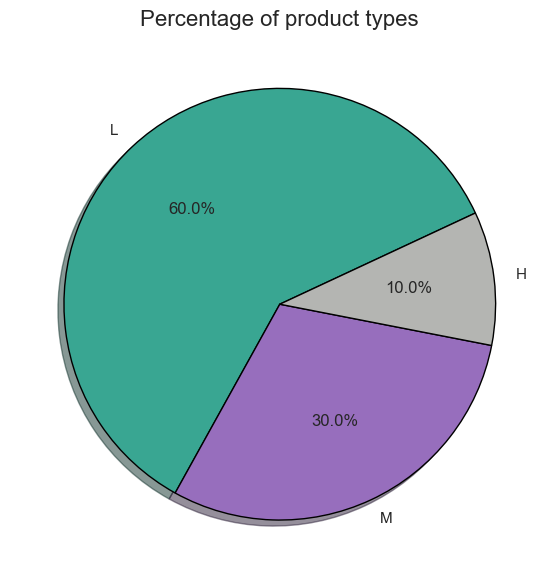

In [59]:
plt.rcParams["figure.figsize"] = (6,6)
colors = ['#39A692', '#976EBD', '#B4B5B2']
plt.pie(df['Type'].value_counts(), labels=['L', 'M', 'H'], colors=colors,
    autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25)

plt.title('Percentage of product types')
plt.tight_layout()

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Percentage of failure wrt product type </span>

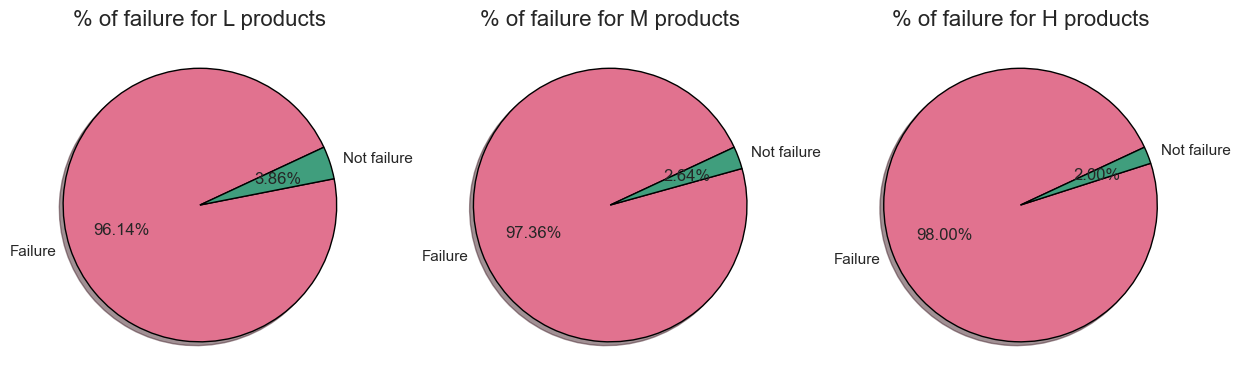

In [60]:
fig, axes = plt.subplots(1,3, figsize=[15,5])
axes.flatten()
j=0
colors = ['#E1728F', '#409E7D'] 
for i in ['L', 'M', 'H']:
    df_product_type = df[df['Type'] == i]
    axes[j].pie(df_product_type['Target'].value_counts(), labels=['Failure', 'Not failure'],
                autopct='%1.2f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25,
                colors=colors)
    axes[j].set_title('% of failure for ' + i + ' products')
    j+=1

**Insight:** L products have a higher ratio of failure compared to the other product types. Moreover, M tends to fail more than H products.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Percentage of failure types </span>

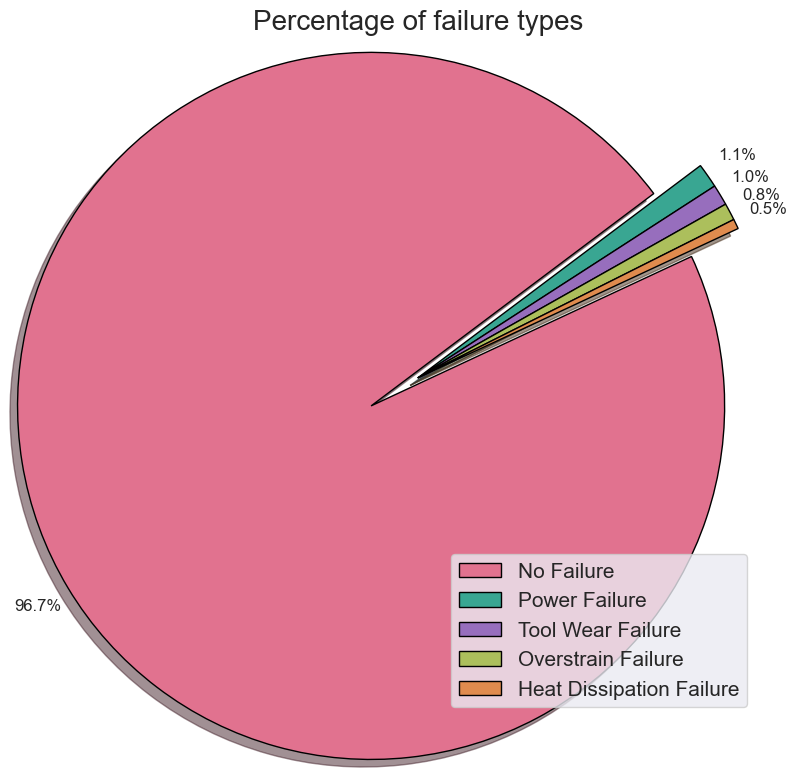

In [61]:
columns_failure_type = df['Failure Type'].unique().tolist()  # Types of failures

plt.rcParams["figure.figsize"] = (8,8)
colors = ['#E1728F', '#39A692', '#976EBD', '#ACBF5C', '#DF8B4E']

plt.pie(df['Failure Type'].value_counts(), explode=(0.2, 0, 0, 0, 0), autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'}, counterclock=False, shadow=True, startangle=25,
        pctdistance=1.1, radius=1.3, colors=colors)
plt.legend(columns_failure_type, loc='lower right', fontsize=15)

plt.title('Percentage of failure types', fontsize=20)
plt.tight_layout()

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Exploring features for each type of failure </span>

Text(0.5, 1.0, 'Excluding class no failure')

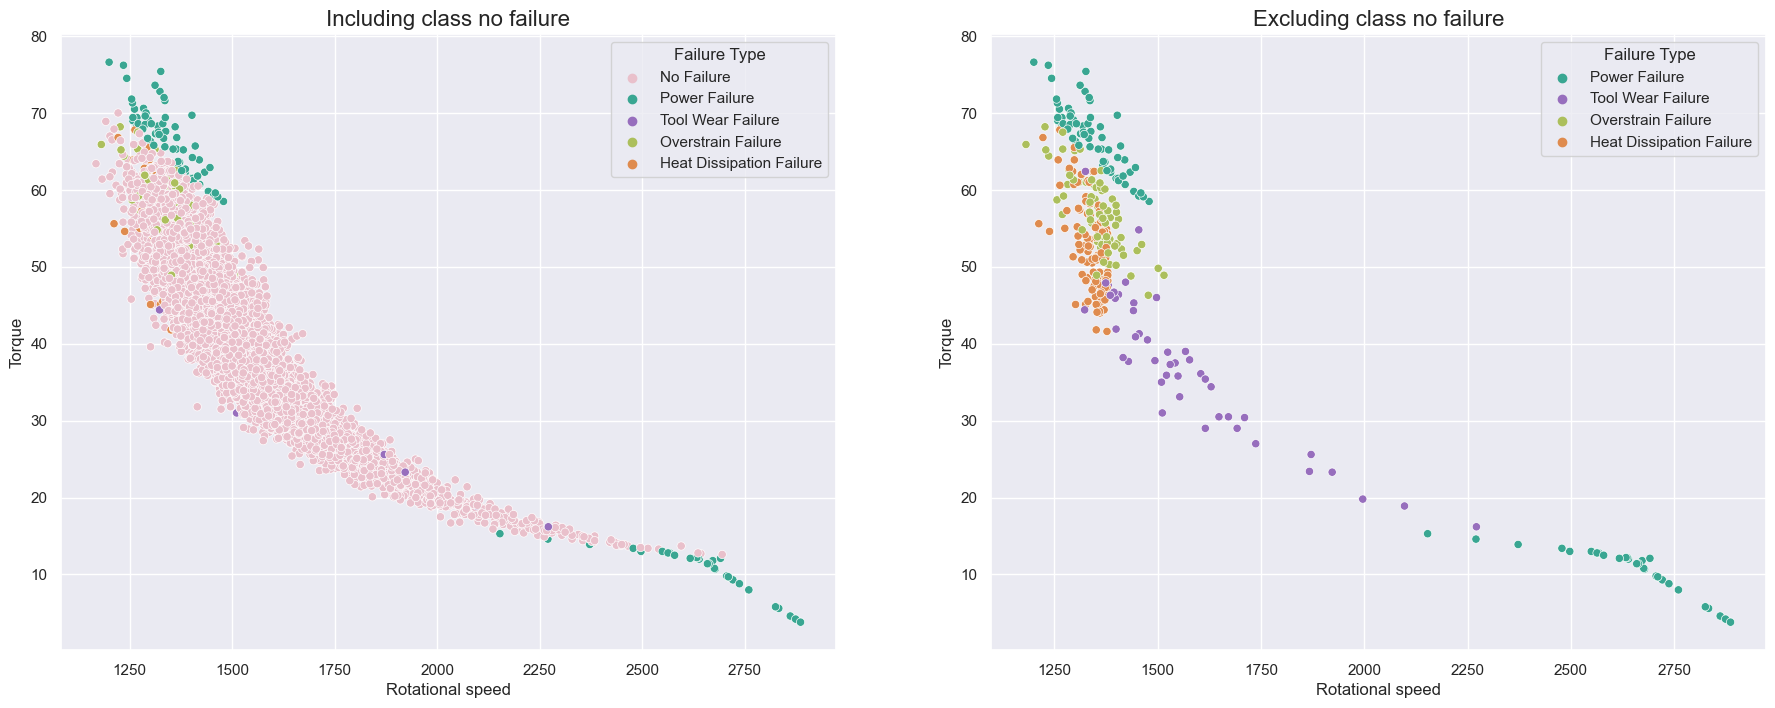

In [62]:
fig, ax = plt.subplots(1,2, figsize=[22,8])
plt.title('Rot. Speed vs Torque wrt Failure Type')
sns.scatterplot(data=df, x='Rotational speed', y='Torque', hue='Failure Type', palette=['#E9C0CB', '#39A692', '#976EBD', '#ACBF5C', '#DF8B4E'], ax=ax[0])
sns.scatterplot(data=df[df['Target'] == 1], x='Rotational speed', y='Torque', hue='Failure Type', palette=['#39A692', '#976EBD', '#ACBF5C', '#DF8B4E'], ax=ax[1])

ax[0].set_title('Including class no failure')
ax[1].set_title('Excluding class no failure')

**Some insights:**
* Power failure happens both for lower and higher rotational speed/torque. It is the type of failure with the highest rotational speed (over 2500rpm) and lowest torque (below around 15Nm). In other others, above and below these thresholds only power failures occur. 
* Between torques 16Nm and 41Nm all failures are tool wear. 
* Overstrain failures take place with torques ranging from around 47 and 68Nm) and rotational speeds from 1200 to 1500rpm approximately.
* For heat dissipation failures, the torque range is smaller and the rotational speed range is bigger compared to overstrain failures.



<span style="color:#26488F; font-size:22px; font-weight: bold;">  Distribution </span> 

----- SKEWNESS ------------
Air temperature skewness = 0.12


C:\Users\vishw\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\vishw\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Process temperature skewness = 0.02
Rotational speed skewness = 1.99


C:\Users\vishw\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\vishw\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Torque skewness = -0.01
Tool wear skewness = 0.03
---------------------------


C:\Users\vishw\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


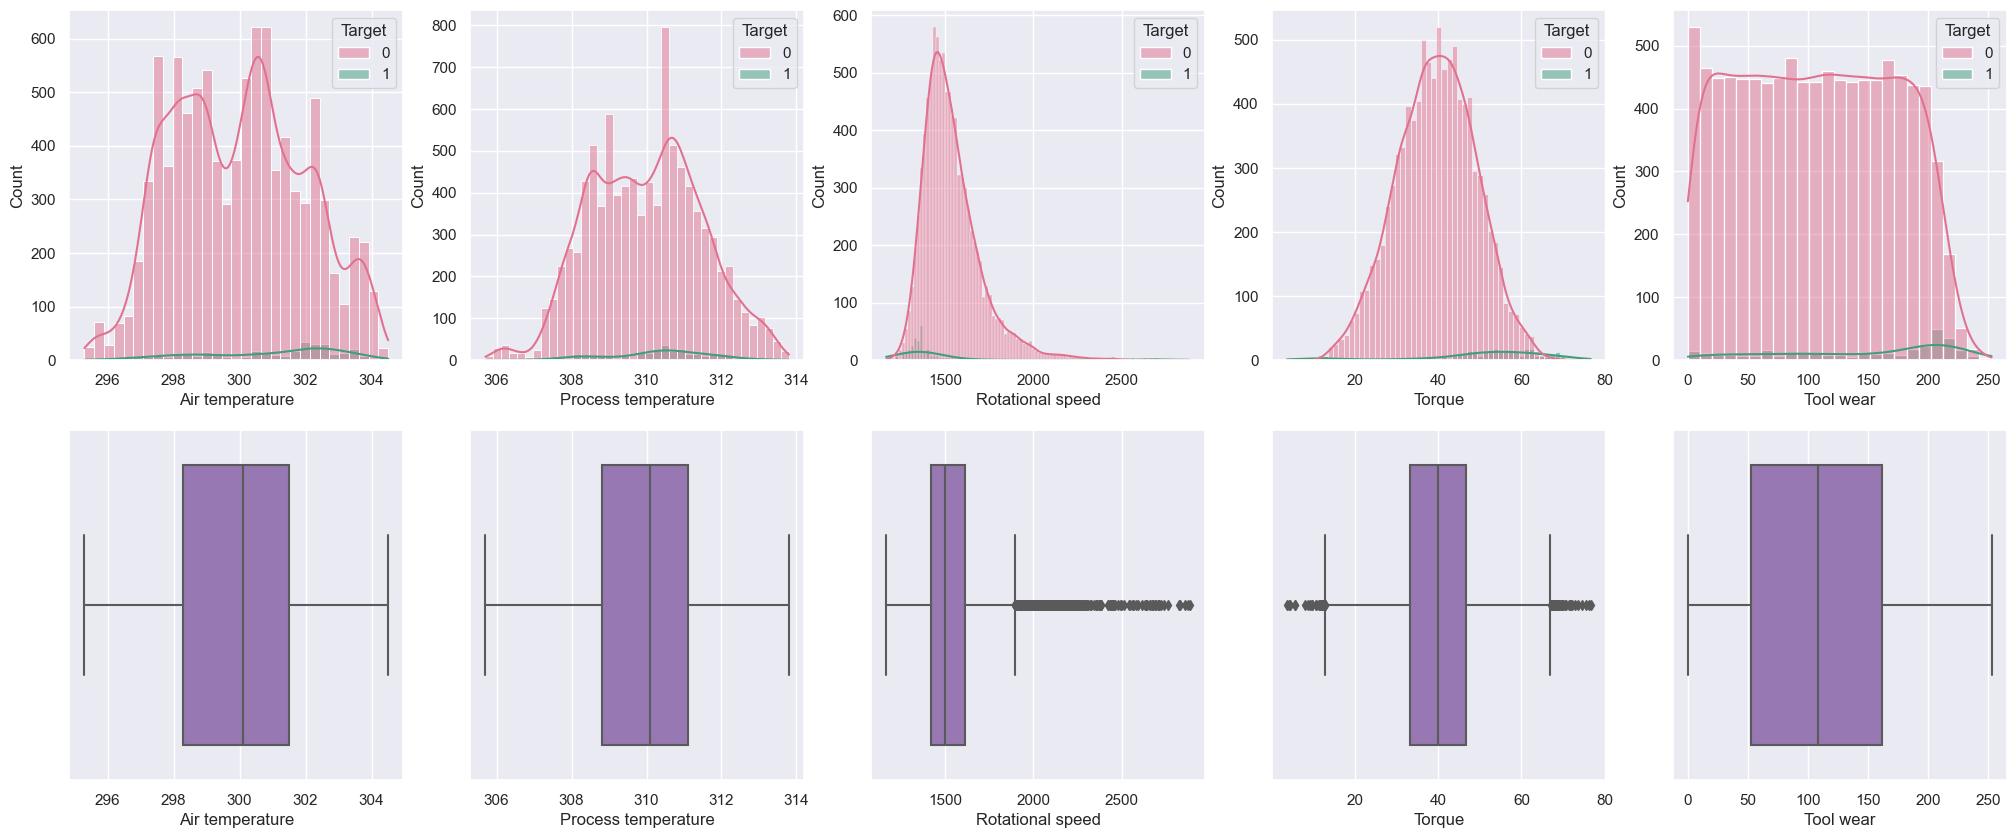

In [63]:
print('----- SKEWNESS ------------')
fig, axes = plt.subplots(2, 5, figsize=[25,10])
j = 0
colors = ['#E1728F', '#409E7D']

for i in ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']:
    sns.histplot(data=df, x=i, kde=True, ax=axes[0,j], hue='Target', palette=colors)
    sns.boxplot(data=df, x=i, ax=axes[1,j], palette=['#976EBD'])
    j+=1
    print('{} skewness = {}'.format(i, round(df[i].skew(), 2)))
print('---------------------------')

* Rotational speed is positively skewed.
* From the boxplots we can see that 'Rotational speed' and 'Torque' have outliers.

Let's check those potential 'outliers' by analyzing the boxplots:


In [64]:
# Function to calculate the maximum and minumum value from the boxplot
def maximum_box(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    maximum = Q3 + 1.5*IQR
    minimum = Q1 - 1.5*IQR
    return maximum, minimum

for i in ['L', 'M', 'H']:
    df_product_type = df[df['Type'] == i]
    max_rotational_speed, min_rotational_speed = maximum_box(df_product_type['Rotational speed'])
    max_torque, min_torque = maximum_box(df_product_type['Torque'])
    print('Values from boxplot for type product ' + i + ':')
    print(f'Maximum torque value: {round(max_torque,2)}')
    print(f'Minimum torque value: {round(min_torque,2)}')
    print(f'Maximum rotational speed value: {round(max_rotational_speed,2)}')
    print(f'Minimum rotational speed value: {round(min_rotational_speed,2)}')
    print('='*20)

Values from boxplot for type product L:
Maximum torque value: 67.2
Minimum torque value: 12.8
Maximum rotational speed value: 1894.0
Minimum rotational speed value: 1142.0
Values from boxplot for type product M:
Maximum torque value: 67.05
Minimum torque value: 13.05
Maximum rotational speed value: 1895.75
Minimum rotational speed value: 1137.75
Values from boxplot for type product H:
Maximum torque value: 66.96
Minimum torque value: 12.66
Maximum rotational speed value: 1894.38
Minimum rotational speed value: 1143.38


**Insight:** The operational range for torque and rotational speed are similar for all product types.

Values above the maximum and below the minimum might be outliers, but not necessarily. 

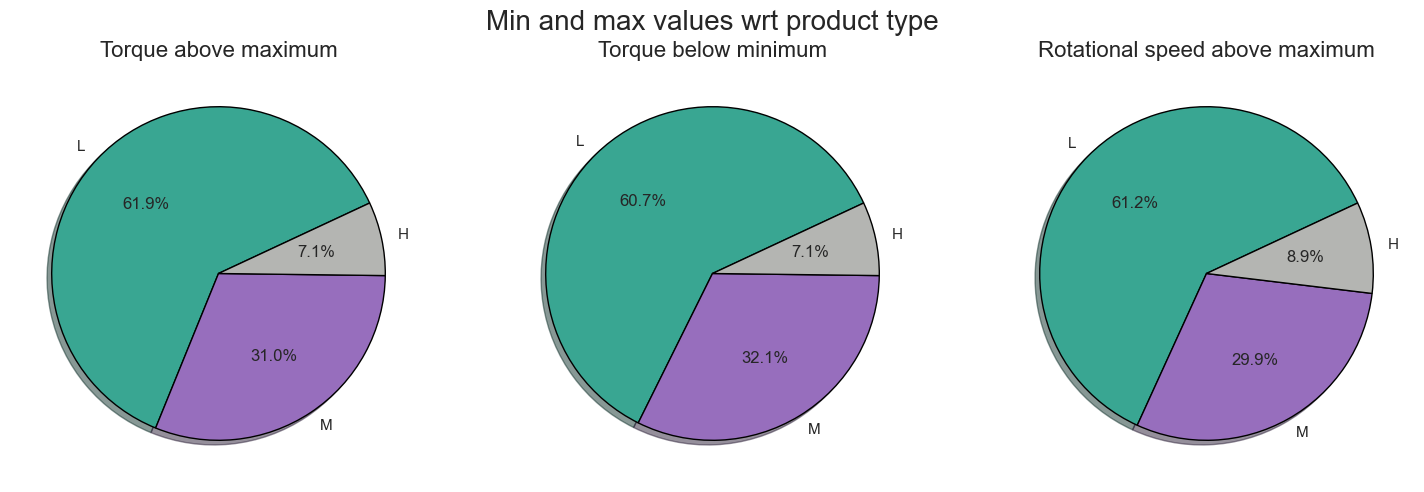

In [65]:
max_rotational_speed, min_rotational_speed = maximum_box(df['Rotational speed'])
max_torque, min_torque = maximum_box(df['Torque'])

max_torque_values = df[df['Torque'] >= max_torque]['Type'].value_counts()  # Torque values above the boxplot maximum
min_torque_values = df[df['Torque'] <= min_torque]['Type'].value_counts()  # Torque values below the boxplot minimum
max_rotational_speed_values = df[df['Rotational speed'] >= max_rotational_speed]['Type'].value_counts()  # Rotational spede values above the boxplot maximum

fig, axes = plt.subplots(1,3, figsize=[15,5])
fig.suptitle('Min and max values wrt product type', fontsize=20)
plt.rcParams['axes.titlesize'] = 16
axes.flatten()
j=0
colors = ['#39A692', '#976EBD', '#B4B5B2']

for i in [max_torque_values, min_torque_values, max_rotational_speed_values]:
    axes[j].pie(i, labels=['L', 'M', 'H'], colors=colors,
        autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25)
    j+=1

axes[0].set_title('Torque above maximum')
axes[1].set_title('Torque below minimum')
axes[2].set_title('Rotational speed above maximum')
plt.tight_layout()

**Insight:** The values above the maximum and below the minimum are not highly correlated with the product type. The proportion of the pies is similar to the 60-30-10 proportion of the entire dataset.

However, there are proportionally slightly more values for L products and less for H across the three scenarios.

In [66]:
total_max_min_values = max_torque_values.sum() + min_torque_values.sum() + max_rotational_speed_values.sum()  # Total of instance under and above the minimum and maximum threshold from the boxplot, respectively.
ratio = total_max_min_values/df.shape[0]  # Percetange of these values with respect to the entire dataset
print('Percentage of values under and above the minimum and maximum threshold from the boxplot: {}'.format(ratio))

Percentage of values under and above the minimum and maximum threshold from the boxplot: 0.048932116715130855


**Insight:** 4.87% of the instances could be considered as ouliers using the boxplot method.

<span style="color:#26488F; font-size:28px; font-weight: bold;">  Data Preprocessing </span>

In [67]:
columns_failure_type = df['Failure Type'].unique().tolist()

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Ordinal Encoding </span>

In [68]:
# Pass on the categorical values
ord_enc = OrdinalEncoder(categories=[['L', 'M', 'H'], columns_failure_type])

# Fit and transform the data for feature 'Type' and target 'Failure Type'
new_dat = ord_enc.fit_transform(df[['Type', 'Failure Type']])
new_dat
df.drop(['Type', 'Failure Type'], axis=1, inplace=True)

new_df = pd.DataFrame(new_dat, 
                      index=df.index, 
                      columns=['Type', 'Failure Type'])

df = pd.concat([df, new_df], axis=1)

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Scaling data </span>

Since 'Rotational spede' and 'Torque' have some outliers, I am going to use RobustScaler:

In [69]:
df_scaled = df.copy()

# Scaling Rotational speed and torque with robust scaler:
columns = ['Rotational speed', 'Torque']
scaler = RobustScaler()
features_scaled = scaler.fit_transform(df[columns])
features_scaled = pd.DataFrame(features_scaled, columns=columns)
df_scaled.drop(columns, axis=1, inplace=True)
df_scaled = pd.concat([df_scaled,features_scaled], axis=1)

df_scaled.head(5)

Air temperature  Process temperature  Tool wear  Target  Type  \
0            298.1                308.6          0       0   1.0   
1            298.2                308.7          3       0   0.0   
2            298.1                308.5          5       0   0.0   
3            298.2                308.6          7       0   0.0   
4            298.2                308.7          9       0   0.0   

   Failure Type  Rotational speed    Torque  
0           0.0          0.253968  0.200000  
1           0.0         -0.502646  0.459259  
2           0.0         -0.026455  0.688889  
3           0.0         -0.370370 -0.044444  
4           0.0         -0.502646 -0.007407

The rest of the features will be scaled with MinMax scaling:

In [77]:
df_scaled["Type"].value_counts()

Type
0.0    5984
1.0    2991
2.0     998
Name: count, dtype: int64

In [70]:
columns = ['Air temperature', 'Process temperature', 'Tool wear']
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(df[columns])
features_scaled = pd.DataFrame(features_scaled, columns=columns)
df_scaled.drop(columns, axis=1, inplace=True)
df_scaled = pd.concat([df_scaled, features_scaled], axis=1)

df_scaled.head()

Target  Type  Failure Type  Rotational speed    Torque  Air temperature  \
0       0   1.0           0.0          0.253968  0.200000         0.304348   
1       0   0.0           0.0         -0.502646  0.459259         0.315217   
2       0   0.0           0.0         -0.026455  0.688889         0.304348   
3       0   0.0           0.0         -0.370370 -0.044444         0.315217   
4       0   0.0           0.0         -0.502646 -0.007407         0.315217   

   Process temperature  Tool wear  
0             0.358025   0.000000  
1             0.370370   0.011858  
2             0.345679   0.019763  
3             0.358025   0.027668  
4             0.370370   0.035573

<span style="color:#26488F; font-size:28px; font-weight: bold;">  Modeling with 'Target' variable </span>

As the dataset is unbalanced, I am going to used macro f1 score and ROC AUC score to assess model performance.

First, let's build a model with 'Target'. Hence, we need to remove the other target 'Failure Type' to avoid data leakage.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Stratified Split </span>

In [71]:
X = df_scaled.drop(['Target', 'Failure Type'], axis=1)
y = df_scaled['Target']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

print('Checking the stratified split...')
print('Target proportion in original dataset:')
print(df['Target'].value_counts(normalize=True))

print('Target proportion in y_train dataset:')
print(y_train.value_counts(normalize=True))

print('Target proportion in y_test dataset:')
print(y_test.value_counts(normalize=True))

Checking the stratified split...
Target proportion in original dataset:
Target
0    0.966911
1    0.033089
Name: proportion, dtype: float64
Target proportion in y_train dataset:
Target
0    0.966974
1    0.033026
Name: proportion, dtype: float64
Target proportion in y_test dataset:
Target
0    0.96672
1    0.03328
Name: proportion, dtype: float64


The proportions are similar. Therefore, it was correctly splitted.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Balanced Models </span>

Let's train some base models to check how they perform.

In [91]:
# Import necessary libraries
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the saved model
model = joblib.load('BalancedRandomForest.joblib')
print("Model loaded successfully")

# Define the correct feature names in the same order as used during model training
correct_feature_names = [
    'Type',
    'Rotational speed',
    'Torque',
    'Air temperature',
    'Process temperature',
    'Tool wear'
]

# Define a function to take sensor data and return a prediction
def predict_failure(type_, rotational_speed, torque, air_temperature, process_temperature, tool_wear):
    # Create a numpy array from the input data
    features = np.array([
        type_,
        rotational_speed,
        torque,
        air_temperature,
        process_temperature,
        tool_wear
    ]).reshape(1, -1)
    
    # Convert to DataFrame with correct feature names
    features_df = pd.DataFrame(features, columns=correct_feature_names)
    
    # Make a prediction using the loaded model
    prediction = model.predict(features_df)[0]
    
    # Convert prediction to human-readable form
    prediction_text = "Failure" if prediction == 1 else "No Failure"
    
    return prediction_text

# Example sensor data
type_ = 1.0
rotational_speed = 1421
torque = 119
air_temperature = 298.4
process_temperature = 308.7
tool_wear = 1

# Get the prediction
prediction = predict_failure(
    type_,
    rotational_speed, 
    torque, 
    air_temperature, 
    process_temperature, 
    tool_wear
)

print("Prediction:", prediction)

# Example test data with correct feature names and order
test_data = {
    'Type': [1.0, 0.0],
    'Rotational speed': [1551, 1500],
    'Torque': [42.8, 40.0],
    'Air temperature': [298.1, 300.0],
    'Process temperature': [308.6, 310.0],
    'Tool wear': [0, 10]
}

# Create a DataFrame with the correct feature names
X_test = pd.DataFrame(test_data, columns=correct_feature_names)

# Example true labels (ensure these match the order of your test data)
y_test = pd.Series([0, 1])  # True labels (0 for No Failure, 1 for Failure)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model loaded successfully
Prediction: Failure
Accuracy: 0.5
Confusion Matrix:
[[0 1]
 [0 1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



C:\Users\vishw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vishw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vishw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


All results are using cross validation:
- **Balanced Bagging is the best overall model**, with highest f1 score and second highest roc auc.
- Balanced Random Forest has a slightly highest roc auc than Balanced Bagging, but its f1 score is lower.
- Easy Ensemble has a high roc auc thant Balance Bagging, but very low f1 score.

In [87]:
# Import necessary libraries
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the saved model
model = joblib.load('BalancedRandomForest.joblib')
print("Model loaded successfully")

# Define the correct feature names in the same order as used during model training
correct_feature_names = [
    'Rotational speed',
    'Torque',
    'Air temperature',
    'Process temperature',
    'Tool wear',
    'Type'
]

# Define a function to take sensor data and return a prediction
def predict_failure(rotational_speed, torque, air_temperature, process_temperature, tool_wear, type_):
    # Create a numpy array from the input data
    features = np.array([
        rotational_speed,
        torque,
        air_temperature,
        process_temperature,
        tool_wear,
        type_
    ]).reshape(1, -1)
    
    # Convert to DataFrame with correct feature names
    features_df = pd.DataFrame(features, columns=correct_feature_names)
    
    # Make a prediction using the loaded model
    prediction = model.predict(features_df)[0]
    
    # Convert prediction to human-readable form
    prediction_text = "Failure" if prediction == 1 else "No Failure"
    
    return prediction_text

# Example sensor data
rotational_speed = 1421
torque = 119
air_temperature = 298.4
process_temperature = 308.7
tool_wear = 1
type_ = 1.0

# Get the prediction
prediction = predict_failure(
    rotational_speed, 
    torque, 
    air_temperature, 
    process_temperature, 
    tool_wear, 
    type_
)

print("Prediction:", prediction)

# Example test data with correct feature names
test_data = {
    'Rotational speed': [1551, 1500],
    'Torque': [42.8, 40.0],
    'Air temperature': [298.1, 300.0],
    'Process temperature': [308.6, 310.0],
    'Tool wear': [0, 10],
    'Type': [1.0, 0.0]
}

# Create a DataFrame with the correct feature names
X_test = pd.DataFrame(test_data, columns=correct_feature_names)

# Example true labels (ensure these match the order of your test data)
y_test = pd.Series([0, 1])  # True labels (0 for No Failure, 1 for Failure)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model loaded successfully


ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


<span style="color:#26488F; font-size:22px; font-weight: bold;">  Roc and precision-recall curves </span>


In [74]:
# Roc curve
def roc_prec_recall_curves(model):
    fig, axList = plt.subplots(ncols=2)
    fig.set_size_inches(16, 8)

    y_prob = model.predict_proba(X_test)

    # ROC-AUC curve
    ax = axList[0]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    ax.plot(fpr, tpr, linewidth=5)
    ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='ROC curve')
    ax.grid(True)

    # Precision-recall curve
    ax = axList[1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
    ax.plot(recall, precision, linewidth=5)
    ax.set(xlabel='Recall', ylabel='Precision',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='Precision-Recall curve')
    ax.grid(True)
    plt.suptitle(str(model).split('(')[0])
    
roc_prec_recall_curves(bag_model)
roc_prec_recall_curves(rf_model)
roc_prec_recall_curves(bal_bag_model)
plt.show()

NameError: name 'bag_model' is not defined

Those plots are using a decision threshold of 0.5 when classiying. As mentioned before, we can play with this number to get a higher recall or precision, considering that there is always a trade-off between them. Let's do that:

<span style="color:#26488F; font-size:18px; font-weight: bold;">  Conclusions </span>

In my opinion, the experts from the maintenance and manufacturing departments should be the ones who choose the model in accordance with their objectives.
- If they are looking for the highest failure detection possible, they should go with the balanced bagging model, thou they would be sacrificing precision with lots of false positives. 
- If they want a balance between precision and recall, perhaps they could choose between the bagging model 0.4 decision threshold or the random forest model with 0.5  threshold. 
- Maybe they do not care much about predicting every failure, but when they do, they want the highest precision possible. In that case, it would be better to opt for the bagging tomek links classifier with a bit higher decision threshold. 

So, the selection of the model depends on the application and desired outcomes.
